In [1]:
# Importing necessary libraries and modules
import warnings  # Import the 'warnings' module for handling warnings
warnings.filterwarnings("ignore")  # Ignore warnings during execution

import gc  # Import the 'gc' module for garbage collection
import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import itertools  # Import 'itertools' for iterators and looping
from collections import Counter  # Import 'Counter' for counting elements
import matplotlib.pyplot as plt  # Import Matplotlib for data visualization
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

# Import custom modules and classes
from imblearn.over_sampling import RandomOverSampler  # Import RandomOverSampler
import accelerate  # Import the 'accelerate' module
import evaluate  # Import the 'evaluate' module

from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel'
from transformers import (  # Import various modules from the Transformers library
    TrainingArguments,  # For training arguments
    Trainer,  # For model training
    ViTImageProcessor,  # For processing image data with ViT models
    ViTForImageClassification,  # ViT model for image classification
    DefaultDataCollator  # For collating data in the default way
)

import torch  # Import PyTorch for deep learning
from torch.utils.data import DataLoader  # For creating data loaders
from torchvision.transforms import (  # Import image transformation functions
    CenterCrop,  # Center crop an image
    Compose,  # Compose multiple image transformations
    Normalize,  # Normalize image pixel values
    RandomRotation,  # Apply random rotation to images
    RandomResizedCrop,  # Crop and resize images randomly
    RandomHorizontalFlip,  # Apply random horizontal flip
    RandomAdjustSharpness,  # Adjust sharpness randomly
    Resize,  # Resize images
    ToTensor  # Convert images to PyTorch tensors
)


In [2]:
from PIL import ImageFile  # Import the necessary module from the Python Imaging Library (PIL)

# Enable the option to load truncated images.
# This setting allows the PIL library to attempt loading images even if they are corrupted or incomplete.
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [3]:
# Import necessary libraries
from pathlib import Path
import pandas as pd  # For creating and handling the DataFrame
import os

# Specify the directory where your dataset is stored
dataset_dir =r"C:\Users\gayat\OneDrive\Documents\Desktop\Deepake Image Detection\Deepfake image detection\Dataset_image"

  # Replace this with the actual path

# Initialize empty lists to store file names and labels
file_names = []
labels = []

# Iterate through all image files in the specified directory
for file in sorted(Path(dataset_dir).glob('*/*/*.*')):
    label = os.path.basename(os.path.dirname(file))  # Extract the label from the file path
    labels.append(label)  # Add the label to the list
    file_names.append(str(file))  # Add the file path to the list

# Print the total number of file names and labels
print("Number of images:", len(file_names))
print("Number of labels:", len(labels))

# Create a pandas DataFrame from the collected file names and labels
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print("DataFrame shape:", df.shape)



Number of images: 190335
Number of labels: 190335
DataFrame shape: (190335, 2)


In [4]:
df.head()

,image,label
0,C:\Users\gayat\OneDrive\Documents\Desktop\Deep...,Fake
1,C:\Users\gayat\OneDrive\Documents\Desktop\Deep...,Fake
2,C:\Users\gayat\OneDrive\Documents\Desktop\Deep...,Fake
3,C:\Users\gayat\OneDrive\Documents\Desktop\Deep...,Fake
4,C:\Users\gayat\OneDrive\Documents\Desktop\Deep...,Fake


In [5]:
df['label'].unique()

array(['Fake', 'Real'], dtype=object)

In [6]:
# y contains the target variable (label) we want to predict
y = df[['label']]

# Drop the 'label' column from the DataFrame 'df' to separate features from the target variable
df = df.drop(['label'], axis=1)

# Create a RandomOverSampler object with a specified random seed (random_state=83)
ros = RandomOverSampler(random_state=83)

# Use the RandomOverSampler to resample the dataset by oversampling the minority class
# 'df' contains the feature data, and 'y_resampled' will contain the resampled target variable
df, y_resampled = ros.fit_resample(df, y)

# Delete the original 'y' variable to save memory as it's no longer needed
del y

# Add the resampled target variable 'y_resampled' as a new 'label' column in the DataFrame 'df'
df['label'] = y_resampled

# Delete the 'y_resampled' variable to save memory as it's no longer needed
del y_resampled

# Perform garbage collection to free up memory used by discarded variables
gc.collect()

print(df.shape)


(190402, 2)


In [7]:
# Create a dataset from a Pandas DataFrame.
# Converts a Pandas DataFrame to a Hugging Face Dataset:

# Dataset.from_pandas(df) creates a Hugging Face Dataset object from the Pandas DataFrame df.
# This is useful when transitioning from tabular data stored in a DataFrame to a Dataset for
# processing or training with Hugging Face tools.

# Casts the "image" Column to the Image Feature Type:

# .cast_column("image", Image()) modifies the Dataset by converting the data in the "image" column
# to a special feature type: Image.

# The Image() feature type allows the Hugging Face Dataset library to handle the column as image data.
# It supports loading and preprocessing images in a manner optimized for machine learning workflows.

dataset = Dataset.from_pandas(df).cast_column("image", Image())


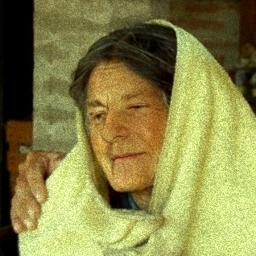

In [8]:
# Display the first image in the dataset
dataset[0]["image"]


In [9]:
# Extracting a subset of elements from the ‘labels’ list using slicing.
# The slicing syntax [:5] selects elements from the beginning up to (but not including) the 5th element.
# This will give us the first 5 elements of the ‘labels’ list.
# The result will be a new list containing these elements.
labels_subset = labels[:5]

# Printing the subset of labels to inspect the content.
print(labels_subset)


['Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [10]:
# Create a list of unique labels by converting ‘labels' to a set and then back to a list
labels_list = ['Real', 'Fake']  # list(set(labels))

# Initialize empty dictionaries to map labels to IDs and vice versa
label2id, id2label = dict(), dict()

# Iterate over the unique labels and assign each label an ID, and vice versa
for i, label in enumerate(labels_list):
    label2id[label] = i  # Map the label to its corresponding ID
    id2label[i] = label  # Map the ID to its corresponding label

# Print the resulting dictionaries for reference
print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)


Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [11]:
# Creating class labels to match labels to IDs
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

# Mapping labels to IDs
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

dataset = dataset.map(map_label2id, batched=True)

# Casting label column to ClassLabel Object
dataset = dataset.cast_column('label', ClassLabels)

# Splitting the dataset into training and testing sets using a 60-40 split ratio
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="label")

# Extracting the training data from the split dataset
train_data = dataset['train']

# Extracting the testing data from the split dataset
test_data = dataset['test']


Casting the dataset: 100%|██████████| 190402/190402 [00:00<00:00, 5437451.03 examples/s]


In [12]:
# Define the pre-trained ViT model string
model_str = "dima806/deepfake_vs_real_image_detection"  # 'google/vit-base-patch16-224-in21k'

# Create a processor for ViT model input from the pre-trained model
processor = ViTImageProcessor.from_pretrained(model_str)

# Retrieve the image mean and standard deviation used for normalization
image_mean, image_std = processor.image_mean, processor.image_std

# Get the size (height) of the ViT model's input images
size = processor.size["height"]
print("Size: ", size)

# Define a normalization transformation for the input images
normalize = Normalize(mean=image_mean, std=image_std)

from torchvision.transforms import Compose, Resize, RandomRotation, ToTensor, Normalize
from torchvision.transforms import InterpolationMode

size = 224  # Define the size for resizing
mean = [0.485, 0.456, 0.406]  # ImageNet mean for normalization
std = [0.229, 0.224, 0.225]  # ImageNet std for normalization

normalize = Normalize(mean=mean, std=std)

# Define a set of transformations for training data
_train_transforms = Compose([
    Resize((size, size), interpolation=InterpolationMode.BILINEAR),  # Resize images to the ViT model's input size
    RandomRotation(90),  # Apply random rotation
    ToTensor(),  # Convert images to tensors
    normalize  # Normalize images using mean and std
])

# Define a set of transformations for validation data
_val_transforms = Compose([
    Resize((size, size), interpolation=InterpolationMode.BILINEAR),  # Resize images to the ViT model's input size
    ToTensor(),  # Convert images to tensors
    normalize  # Normalize images using mean and std
])


# Define a function to apply training transformations to a batch of examples
def train_transforms(examples):
    examples["pixel_values"] = [_train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

# Define a function to apply validation transformations to a batch of examples
def val_transforms(examples):
    examples["pixel_values"] = [_val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


Size:  224


In [13]:
# Set the transforms for the training data
train_data.set_transform(train_transforms)

# Set the transforms for the test/validation data
test_data.set_transform(val_transforms)


In [14]:
# Define a collate function that prepares batched data for model training.
def collate_fn(examples):
    # Stack the pixel values from individual examples into a single tensor.
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
   
    # Convert the label strings in examples to corresponding numeric IDs using label2id dictionary.
    labels = torch.tensor([example["label"] for example in examples])
   
    # Return a dictionary containing the batched pixel values and labels.
    return {"pixel_values": pixel_values, "labels": labels}

In [15]:
# Create a ViTForImageClassification model from a pretrained checkpoint with a specified number of output labels.
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))

# Configure the mapping of class labels to their corresponding indices for later reference.
model.config.id2label = id2label
model.config.label2id = label2id

# Calculate and print the number of trainable parameters in millions for the model.
print(model.num_parameters(only_trainable=True) / 1e6)


85.800194


In [16]:
# Load the accuracy metric from a module named "evaluate"
accuracy = evaluate.load("accuracy")

# Define a function 'compute_metrics' to calculate evaluation metrics
def compute_metrics(eval_pred):
    # Extract model predictions from the evaluation prediction object
    predictions = eval_pred.predictions

    # Extract true labels from the evaluation prediction object
    label_ids = eval_pred.label_ids

    # Calculate accuracy using the loaded accuracy metric
    # Convert model predictions to class labels by selecting the class with the highest probability (argmax)
    predicted_labels = predictions.argmax(axis=1)

    # Calculate accuracy score by comparing predicted labels to true labels
    acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']

    # Return the computed accuracy as a dictionary with the key "accuracy"
    return {
        "accuracy": acc_score
    }

Using the latest cached version of the module from C:\Users\gayat\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--accuracy\f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Sun Jan 19 18:34:45 2025) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.


In [17]:
# Define the name of the evaluation metric to be used during training and evaluation.
metric_name = "accuracy"

# Define the name of the model, which will be used to create a directory for saving model checkpoints and outputs.
model_name = "deepfake_vs_real_image_detection"

# Define the number of training epochs for the model.
num_train_epochs = 2

# Create an instance of TrainingArguments to configure training settings.
args = TrainingArguments(
    # Specify the directory where model checkpoints and outputs will be saved.
    output_dir=model_name,
   
    # Specify the directory where training logs will be stored.
    logging_dir="./logs",
   
    # Define the evaluation strategy, which is performed at the end of each epoch.
    evaluation_strategy="epoch",
   
    # Set the learning rate for the optimizer.
    learning_rate=1e-6,
   
    # Define the batch size for training on each device.
    per_device_train_batch_size=32,
   
    # Define the batch size for evaluation on each device.
    per_device_eval_batch_size=8,
   
    # Specify the total number of training epochs.
    num_train_epochs=num_train_epochs,
   
    # Apply weight decay to prevent overfitting.
    weight_decay=0.02,
   
    # Set the number of warm-up steps for the learning rate scheduler.
    warmup_steps=50,
   
    # Disable the removal of unused columns from the dataset.
    remove_unused_columns=False,

   # Define the strategy for saving model checkpoints (per epoch in this case).
    save_strategy="epoch",

   # Load the best model at the end of training.
    load_best_model_at_end=True,

   # Limit the total number of saved checkpoints to save space.
    save_total_limit=1,

   # Specify that training progress should not be reported.
   report_to="none"
 
)


In [18]:
# Create a Trainer instance for fine-tuning a language model.
# - model: The pre-trained language model to be fine-tuned.
# - args: Configuration settings and hyperparameters for training.
# - train_dataset: The dataset used for training the model.
# - eval_dataset: The dataset used for evaluating the model during training.
# - data_collator: A function that defines how data batches are collated and processed.
# - compute_metrics: A function for computing custom evaluation metrics.
# - tokenizer: The tokenizer used for processing text data.

trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor
)


In [19]:
# Start training the model using the trainer object.
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.063700,0.032819,0.988708
2,0.059200,0.032114,0.989325


TrainOutput(global_step=7142, training_loss=0.07014597153269721, metrics={'train_runtime': 247214.6871, 'train_samples_per_second': 0.924, 'train_steps_per_second': 0.029, 'total_flos': 1.770552477112121e+19, 'train_loss': 0.07014597153269721, 'epoch': 2.0})

In [20]:
trainer.evaluate()

{'eval_loss': 0.03211371973156929,
 'eval_accuracy': 0.9893252452042384,
 'eval_runtime': 9365.01,
 'eval_samples_per_second': 8.133,
 'eval_steps_per_second': 1.017,
 'epoch': 2.0}

In [22]:
outputs=trainer.predict(test_data)

In [23]:
print(outputs.metrics)

{'test_loss': 0.03211371973156929, 'test_accuracy': 0.9893252452042384, 'test_runtime': 13880.5691, 'test_samples_per_second': 5.487, 'test_steps_per_second': 0.686}


In [24]:
trainer.save_model()

Accuracy: 0.9893
F1 Score: 0.9893


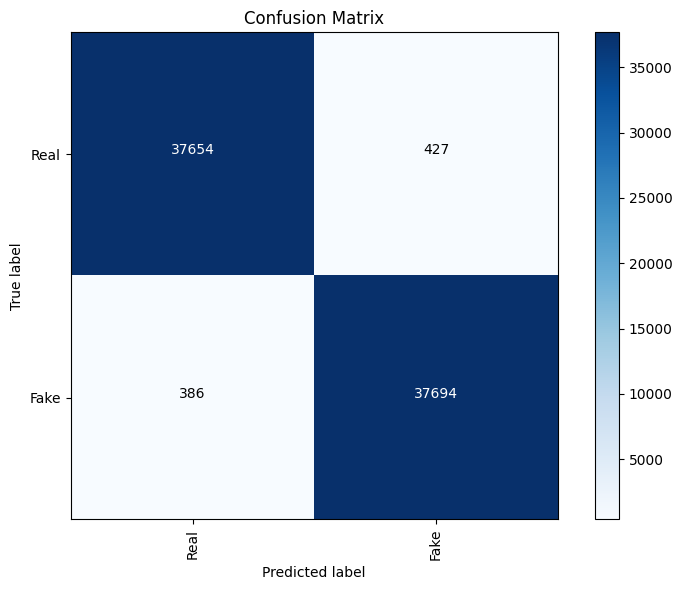


Classification report:

              precision    recall  f1-score   support

        Real     0.9899    0.9888    0.9893     38081
        Fake     0.9888    0.9899    0.9893     38080

    accuracy                         0.9893     76161
   macro avg     0.9893    0.9893    0.9893     76161
weighted avg     0.9893    0.9893    0.9893     76161



In [ ]:
# Extract the true labels from the model outputs
y_true = outputs.label_ids

# Predict the labels by selecting the class with the highest probability
y_pred = outputs.predictions.argmax(1)

# Define a function to plot a confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    # Add text annotations to the plot indicating the values in the cells
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()

    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print('Classification report:')
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))